In [37]:
import os
import json
import cv2
from matplotlib import pyplot as plt
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from skimage.util import random_noise
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import dataclasses
from dataclasses import dataclass
import math
import random
from scipy import stats
import os
import pickle

In [38]:
class FashionCNN(nn.Module):
    def __init__(self, num_output_classes):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=num_output_classes)
        self.logits = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.layer1(x)
        print("L1", out)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.logits(out)
        
        return out
    
    def get_representation(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        return out

class TemperatureScalingCalibrationModule(nn.Module):

    def __init__(self, model):
        super().__init__()
        self.model = model

        # the single temperature scaling parameter, the initialization value doesn't
        # seem to matter that much based on some ad-hoc experimentation
        self.temperature = nn.Parameter(torch.ones(1))
        
    def get_representation(self, x):
        return self.model.get_representation(x)
        
    def forward_unscaled(self, x):
        logits = self.model(x)
        scores = nn.functional.softmax(logits, dim=1)
        return scores
    
    def forward(self, x):
        scaled_logits = self.forward_logit(x)
        scores = nn.functional.softmax(scaled_logits, dim=1)
        return scores

    def forward_logit(self, x):      
        logits = self.model(x)
        return logits / self.temperature

    def fit(self, data_loader, n_epochs: int = 10, batch_size: int = 64, lr: float = 0.01):
        """fits the temperature scaling parameter."""
        assert isinstance(data_loader, DataLoader), "data_loader must be an instance of DataLoader"
    
        print(self.temperature.requires_grad)
        
        self.freeze_base_model()
        criterion = nn.NLLLoss()
        optimizer = optim.SGD(self.parameters(), lr=lr)
        
        for epoch in range(n_epochs):
            for batch in data_loader:
                images, labels, _ = batch  
                images, labels = images.to(device), labels.to(device)
        
                self.zero_grad()
                scaled_logits = self.forward_logit(images)  # Use forward to get scaled logits
                loss = criterion(scaled_logits, labels)
                loss.backward()
                optimizer.step()
    
        return self


    def freeze_base_model(self):
        """remember to freeze base model's parameters when training temperature scaler"""
        self.model.eval()
        for parameter in self.model.parameters():
            parameter.requires_grad = False

        return self

print(TemperatureScalingCalibrationModule(FashionCNN(num_output_classes=12)))

TemperatureScalingCalibrationModule(
  (model): FashionCNN(
    (layer1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc1): Linear(in_features=2304, out_features=600, bias=True)
    (drop): Dropout2d(p=0.25, inplace=False)
    (fc2): Linear(in_features=600, out_features=120, bias=True)
    (fc3): Linear(in_features=120, out_features=12, bias=True)
    (logits): LogSoftmax(dim=1)
  )
)


In [39]:
pitch_model = TemperatureScalingCalibrationModule(FashionCNN(num_output_classes=11))
pitch_model.load_state_dict(torch.load("./model_pitch.std"))

secondary_model = TemperatureScalingCalibrationModule(FashionCNN(num_output_classes=7))
secondary_model.load_state_dict(torch.load("./model_secondary.std"))


<All keys matched successfully>

In [40]:
class_to_annotation =  {
            "pitch": {0: "HE", 1: "SI", 2: "YI", 3: "SHANG", 4: "GOU", 5: "CHE", 6: "GONG", 7: "FAN", 8: "LIU", 9: "WU", 10: "GAO_WU"},
            "secondary": {0: None, 1: "DA_DUN", 2: "XIAO_ZHU", 3: "DING_ZHU", 4: "DA_ZHU", 5: "ZHE", 6: "YE"}
}

annotation_to_class = {
    "pitch": {"HE": 0, "SI": 1, "YI": 2, "SHANG": 3, "GOU": 4, "CHE": 5, "GONG": 6, "FAN": 7, "LIU": 8, "WU": 9, "GAO_WU": 10},
    "secondary": {None: 0, "DA_DUN": 1, "XIAO_ZHU": 2, "DING_ZHU": 3, "DA_ZHU": 4, "ZHE": 5, "YE": 6}
}

## this function takes the path_to_folder (i.e., the folder where the dataset.json is in)
## and returns a list of the dataset entries. Each entry consists of the keys:
##     "image_path": 
##     "type": The type of the box (in our case, this is 'Music' only)
##     "annotation": The annotation string
##     "image": The image as uint8 array representation
##     "is_simple": This is True if the notation is "simple notation" as opposed to "composite notation"
def open_dataset(path_to_folder):
    path_to_json = os.path.join(path_to_folder, "dataset.json")
    with open(path_to_json) as file:
        dataset_json = json.load(file)
        output_list = []
        
        for idx in range(len(dataset_json)):
            if dataset_json[idx]["annotation"]["pitch"] is None or dataset_json[idx]["annotation"]["pitch"] == "None":
                continue
            temp_dict = {}
            temp_dict["image"] = cv2.imread(os.path.join(path_to_folder, dataset_json[idx]["image_path"]), cv2.IMREAD_GRAYSCALE)
            temp_dict["is_simple"] = True if dataset_json[idx]["annotation"]["secondary"] == None else False
            temp_dict["annotation"] = {}
            temp_dict["annotation"]["pitch"] = annotation_to_class["pitch"][dataset_json[idx]["annotation"]["pitch"]]
            temp_dict["annotation"]["secondary"] = annotation_to_class["secondary"][dataset_json[idx]["annotation"]["secondary"]]
            temp_dict["edition"] = os.path.basename(dataset_json[idx]["image_path"]).split("_")[0]
            temp_dict["image_id"] = "_".join(dataset_json[idx]["image_path"].split("_")[:-1])
            temp_dict["image_path"] = os.path.basename(dataset_json[idx]["image_path"])
            output_list.append(temp_dict)
    return output_list

def get_cropped_dataset(dataset):  ## creates a new dataset where each of the images is cropped
    
    def remove_small_blobs(image):  # remove small isolated connected black areas
        noise_removal_threshold = 1  
        mask = np.ones_like(image)*255
        contours, hierarchy = cv2.findContours(255-image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for contour in contours:
          area = cv2.contourArea(contour)
          if area >= noise_removal_threshold:
            cv2.fillPoly(mask, [contour], 0)
        return mask


    def crop_excess_whitespace(image):
        gray = 255*(image < 128).astype(np.uint8) #reverse the colors
        coords = cv2.findNonZero(gray) # Find all non-zero points (text)
        x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
        rect = image[y:y+h, x:x+w]
        return rect

    cropped_dataset = copy.deepcopy(dataset)
    for idx in range(len(cropped_dataset)):
        cropped_dataset[idx]["image"] = crop_excess_whitespace(remove_small_blobs(dataset[idx]["image"]))
    return cropped_dataset

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    shrink(is_random=False),
    paste_to_square(is_random=False),
    lambda img: transforms.functional.invert(img), # inverts image, needed for rotations
    normalize(), # normalize mean and variance
])

validation_transforms = transforms.Compose([
    transforms.ToTensor(),
    shrink(is_random=False),
    paste_to_square(is_random=False),
    lambda img: transforms.functional.invert(img), # inverts image, needed for rotations
    normalize(), # normalize mean and variance
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    shrink(is_random=False),
    paste_to_square(is_random=False),
    lambda img: transforms.functional.invert(img), # inverts image, needed for rotations
    normalize(), # normalize mean and variance
])


@dataclass
class ValidationEditions:  # This parameter chooses which edition is used for validation. The other editions are for training.
    NONE: str = "none"
    LU: str = "lu"
    ZHANG: str = "zhang"
    SIKU: str = "siku"
    ZHU: str = "zhu"

@dataclass
class LabelType:
    #PITCH: str = "pitch"
    PITCH_BALANCED: str = "pitch_balanced"
    #SECONDARY: str = "secondary"
    SECONDARY_BALANCED: str = "secondary_balanced"

class Dataset(torch.utils.data.Dataset):
    def __init__(self, label_type, dataset: list, transform=None):
        self.X = [entry["image"] for entry in dataset]

        if label_type.split("_")[0] == "pitch":
            self.y = [entry["annotation"]["pitch"] for entry in dataset]
        else:
            self.y = [entry["annotation"]["secondary"] for entry in dataset]

        self.is_simple = [entry["is_simple"] for entry in dataset]


        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = self.X[idx]
        if self.transform:
            sample = self.transform(sample)
        label = self.y[idx]
        is_simple = self.is_simple[idx]
        return sample, label, is_simple
            
def get_dataloaders(dataset, validation_edition=ValidationEditions.NONE, label_type=LabelType.PITCH_BALANCED, is_test_loader=False):
    def get_datasets():
        if validation_edition is not ValidationEditions.NONE:
            train_data = Dataset(label_type, [entry for entry in dataset if entry["edition"]!=validation_edition], transform=train_transforms)
            validation_data = Dataset(label_type, [entry for entry in dataset if entry["edition"]==validation_edition], transform=validation_transforms)
            test_data = Dataset(label_type, [entry for entry in dataset if entry["edition"]==validation_edition], transform=test_transforms)
        else:
            # random shuffling the data
            indices = [i for i in range(len(dataset))]
            np.random.shuffle(indices)
            split = int(len(dataset) * 0.8) # 80% of data
            train_data = Dataset(label_type, dataset[:split], transform=train_transforms)
            validation_data = Dataset(label_type, dataset[split:], transform=validation_transforms)
            test_data = Dataset(label_type, dataset[split:], transform=test_transforms)
        return train_data, validation_data, test_data
    
    def get_dataloaders(train_data, validation_data, test_data):
        def get_sampler(y):
            inverse_class_weights = 1/np.unique(y, return_counts=True)[1]
            inverse_weigths = [inverse_class_weights[int(label)] for label in y]
                
            return torch.utils.data.WeightedRandomSampler(weights=inverse_weigths, num_samples=60000, replacement=True)

        def get_val_sampler(y):
            inverse_class_weights = 1/np.unique(y, return_counts=True)[1]
            inverse_weigths = [inverse_class_weights[int(label)] for label in y]
                
            return torch.utils.data.WeightedRandomSampler(weights=inverse_weigths, num_samples=len(y), replacement=True)
        
        sample = "balanced" in label_type
                    
        train_sampler = get_sampler(train_data.y) if sample else None
        validation_sampler = get_val_sampler(validation_data.y) if sample else None

        loaders = {
            'train' : torch.utils.data.DataLoader(train_data, 
                                                  batch_size=100, 
                                                  sampler=train_sampler),

            'validation'  : torch.utils.data.DataLoader(validation_data, 
                                                  batch_size=100, 
                                                  sampler=validation_sampler),
            'test'  : torch.utils.data.DataLoader(test_data, 
                                                  batch_size=100),
        }
        
        return loaders
    
    train_data, validation_data, test_data = get_datasets()
    

    return get_dataloaders(train_data, validation_data, test_data)

def get_all_dataloaders(dataset):
    dataloader_dict = {}
    for val_edition in dataclasses.astuple(ValidationEditions()):
        dataloader_dict[val_edition] = {}
        for label_type in dataclasses.astuple(LabelType()):
            dataloader_dict[val_edition][label_type] = get_dataloaders(dataset, val_edition, label_type)
    return dataloader_dict

def get_test_dataloaders(dataset):
    return {
        LabelType.PITCH_BALANCED: torch.utils.data.DataLoader(Dataset(LabelType.PITCH_BALANCED, dataset, transform=test_transforms), batch_size=100),
        LabelType.SECONDARY_BALANCED: torch.utils.data.DataLoader(Dataset(LabelType.SECONDARY_BALANCED, dataset, transform=test_transforms), batch_size=100)
    }

def visualize_dataloader(dl, to_string=None):
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dl.dataset), size=(1,)).item()
        img, label, _ = dl.dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        
        if to_string is not None:
            label = class_to_annotation[to_string][label]
            
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

In [41]:
def shrink(is_random=True):
    def inner(input_image):
         
        t_size = random.randint(15, 22) if is_random else 20
        
        original_width = input_image.shape[-1]
        original_height = input_image.shape[-2]
        aspect_ratio = original_width / original_height * random.uniform(0.6, 1.5) if is_random else original_width / original_height
        
        if aspect_ratio > 1:
            w = int(t_size)
            h = int(t_size / aspect_ratio)
        else: 
            w = int(t_size * aspect_ratio)
            h = int(t_size)

        output_image = transforms.Resize(size=(h, w), interpolation=transforms.InterpolationMode.NEAREST_EXACT)(input_image)
        return output_image
    
    return inner

def paste_to_square(is_random=True, target_size=28):
    def inner(input_image):
        ## Modify the function to extend the
        ## input image to a square of 40x40.
        ## Tip: This can be done by clever use
        ## of the Pad function
        ## https://pytorch.org/vision/stable/generated/torchvision.transforms.Pad.html
        ## Also make sure that the added padding
        ## on each side is random, i.e., the 
        ## data itself is augmented by its
        ## position in the square.
                
        pad_width = target_size - input_image.shape[-1]
        pad_height = target_size - input_image.shape[-2]
        
        left_pad = random.randint(0, pad_width) if is_random else pad_width//2
        top_pad = random.randint(0, pad_height) if is_random else pad_height//2
        
        right_pad = pad_width - left_pad
        bottom_pad = pad_height - top_pad
            
        output_image = transforms.Pad(padding=(left_pad, top_pad, right_pad, bottom_pad), fill=1)(input_image) 
        return output_image
    
    return inner

def salt_and_pepper(percentage=0.1):
    def inner(input_image):
        output_image = input_image.numpy().squeeze()
        if random.uniform(0, 1) < percentage/2:
            amount = 0.02
            output_image = random_noise(output_image, mode='salt', amount=amount)
        if random.uniform(0, 1) < percentage/2:
            amount = 0.01
            output_image = random_noise(output_image, mode='pepper', amount=amount)
        return torch.Tensor(output_image).unsqueeze(0)
    return inner

def erode(percentage=0.1):
    def inner(input_image):
        if random.uniform(0, 1) < percentage:  # only apply transformation according to percentage
            kernel = np.ones((2,2),np.uint8)
            output_image = cv2.erode(input_image, kernel, iterations=1)
            return output_image
        else:
            return input_image
    return inner

def dilate(percentage=0.1):
    def inner(input_image):
        if random.uniform(0, 1) < percentage:  # only apply transformation according to percentage
            kernel = np.ones((2,2),np.uint8)
            output_image = cv2.dilate(input_image, kernel, iterations=1)
            return output_image
        else:
            return input_image
    return inner

## Normalizes the dataset to have mean 0 and standard deviation of 1
## --> good for later model performance
#mean_list = torch.Tensor([torch.Tensor(entry["image"]).mean() for entry in dataset])/255
#mean = mean_list.mean()
#std = mean_list.std()

def normalize():
    return transforms.Normalize(mean=0.7102, std=0.0914)

In [42]:
with open('train_data.pkl', 'rb') as handle:
    train_dataset = pickle.load(handle)
with open('test_data.pkl', 'rb') as handle:
    test_dataset = pickle.load(handle)
train_dataloaders = get_all_dataloaders(train_dataset)
test_dataloaders = get_test_dataloaders(test_dataset)

print(test_dataloaders.keys())

dict_keys(['pitch_balanced', 'secondary_balanced'])


In [43]:
class_to_annotation =  {
            "pitch": {0: "HE", 1: "SI", 2: "YI", 3: "SHANG", 4: "GOU", 5: "CHE", 6: "GONG", 7: "FAN", 8: "LIU", 9: "WU", 10: "GAO_WU"},
            "secondary": {0: None, 1: "DA_DUN", 2: "XIAO_ZHU", 3: "DING_ZHU", 4: "DA_ZHU", 5: "ZHE", 6: "YE"}
}

annotation_to_class = {
    "pitch": {"HE": 0, "SI": 1, "YI": 2, "SHANG": 3, "GOU": 4, "CHE": 5, "GONG": 6, "FAN": 7, "LIU": 8, "WU": 9, "GAO_WU": 10},
    "secondary": {None: 0, "DA_DUN": 1, "XIAO_ZHU": 2, "DING_ZHU": 3, "DA_ZHU": 4, "ZHE": 5, "YE": 6}
}

## this function takes the path_to_folder (i.e., the folder where the dataset.json is in)
## and returns a list of the dataset entries. Each entry consists of the keys:
##     "image_path": 
##     "type": The type of the box (in our case, this is 'Music' only)
##     "annotation": The annotation string
##     "image": The image as uint8 array representation
##     "is_simple": This is True if the notation is "simple notation" as opposed to "composite notation"
def open_dataset(path_to_folder):
    path_to_json = os.path.join(path_to_folder, "dataset.json")
    with open(path_to_json) as file:
        dataset_json = json.load(file)
        output_list = []
        
        for idx in range(len(dataset_json)):
            if dataset_json[idx]["annotation"]["pitch"] is None or dataset_json[idx]["annotation"]["pitch"] == "None":
                continue
            temp_dict = {}
            temp_dict["image"] = cv2.imread(os.path.join(path_to_folder, dataset_json[idx]["image_path"]), cv2.IMREAD_GRAYSCALE)
            temp_dict["is_simple"] = True if dataset_json[idx]["annotation"]["secondary"] == None else False
            temp_dict["annotation"] = {}
            temp_dict["annotation"]["pitch"] = annotation_to_class["pitch"][dataset_json[idx]["annotation"]["pitch"]]
            temp_dict["annotation"]["secondary"] = annotation_to_class["secondary"][dataset_json[idx]["annotation"]["secondary"]]
            temp_dict["edition"] = os.path.basename(dataset_json[idx]["image_path"]).split("_")[0]
            temp_dict["image_id"] = "_".join(dataset_json[idx]["image_path"].split("_")[:-1])
            temp_dict["image_path"] = os.path.basename(dataset_json[idx]["image_path"])
            output_list.append(temp_dict)
    return output_list

def get_cropped_dataset(dataset):  ## creates a new dataset where each of the images is cropped
    
    def remove_small_blobs(image):  # remove small isolated connected black areas
        noise_removal_threshold = 1  
        mask = np.ones_like(image)*255
        contours, hierarchy = cv2.findContours(255-image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for contour in contours:
          area = cv2.contourArea(contour)
          if area >= noise_removal_threshold:
            cv2.fillPoly(mask, [contour], 0)
        return mask


    def crop_excess_whitespace(image):
        gray = 255*(image < 128).astype(np.uint8) #reverse the colors
        coords = cv2.findNonZero(gray) # Find all non-zero points (text)
        x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
        rect = image[y:y+h, x:x+w]
        return rect

    cropped_dataset = copy.deepcopy(dataset)
    for idx in range(len(cropped_dataset)):
        cropped_dataset[idx]["image"] = crop_excess_whitespace(remove_small_blobs(dataset[idx]["image"]))
    return cropped_dataset

validation_transforms = transforms.Compose([
    transforms.ToTensor(),
    shrink(is_random=False),
    paste_to_square(is_random=False),
    lambda img: transforms.functional.invert(img), # inverts image, needed for rotations
    normalize(), # normalize mean and variance
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    shrink(is_random=False),
    paste_to_square(is_random=False),
    lambda img: transforms.functional.invert(img), # inverts image, needed for rotations
    normalize(), # normalize mean and variance
])



In [44]:
def get_transformation(model, l):
    return model.get_representation(l)
    
def get_datasets(dataset, transformation=False):
    class Dataset(torch.utils.data.Dataset):
        def __init__(self, return_pitch, dataset: list, model=None, tf=None):
            model.eval()
            concatenation = torch.cat([tf(entry["image"]).unsqueeze(0) for entry in dataset])
            
            if tf:
                self.X = get_transformation(model, concatenation)
            else:
                self.X = [tf(entry["image"]) for entry in dataset]
                
            self.original = [entry["image"] for entry in dataset]
            
            if return_pitch:
                self.y = [entry["annotation"]["pitch"] for entry in dataset]
            else:
                self.y = [entry["annotation"]["secondary"] for entry in dataset]


            self.transform = tf

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            sample = self.X[idx]
            label = self.y[idx]
            return sample, label
    
    pitch_data = Dataset(return_pitch=True, dataset=dataset, model=pitch_model, tf=validation_transforms)
    secondary_data = Dataset(return_pitch=False, dataset=dataset, model=secondary_model, tf=validation_transforms)
    return {"pitch": pitch_data, "secondary": secondary_data}

with open("train_data.pkl", "rb") as file_handle:
    dataset = pickle.load(file_handle)
datasets = get_datasets(dataset, False)

import umap

datasets = get_datasets(dataset, True)
umap_pitch = umap.UMAP(random_state=42).fit(datasets["pitch"].X.detach().numpy())
umap_secondary = umap.UMAP(random_state=42).fit(datasets["secondary"].X.detach().numpy())

/home/tristan/.local/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/home/tristan/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/tristan/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_s

In [45]:
#print(datasets["pitch"][0][0].shape)
print(datasets["pitch"][0][0])

tensor([ 3.3328e+00, -2.7188e+00,  1.9509e+00,  1.0748e+00, -3.5875e-01,
         1.4942e+01,  1.2711e+01,  6.3245e-01,  3.2917e-01, -5.2898e-02,
        -6.3688e-01, -7.3919e+00,  9.5435e-01,  6.8031e+00,  1.7211e+00,
        -2.8178e-01,  4.5733e-01,  3.5761e+00,  3.1148e+00,  1.5939e-01,
         5.6390e-01, -4.9072e-01,  7.5381e-01,  9.0692e-01,  6.5995e-01,
        -4.8828e-01,  1.0348e+01,  3.0315e+00, -4.1578e+00, -1.0150e+01,
         7.5478e-02,  7.3415e-01,  4.0056e+00, -1.5755e+01,  3.1235e-01,
         1.5268e-01, -5.9329e-03,  1.0622e+00,  7.2680e+00, -9.0575e-01,
        -3.8055e+00, -5.6613e+00, -6.7834e-01,  5.5946e+00,  9.5677e+00,
         2.7827e-01,  3.2632e+00, -3.7490e-01, -5.3324e-01,  5.0247e-01,
        -7.1076e+00,  8.9505e-01, -7.7039e+00,  2.1075e-02, -9.6760e+00,
         5.5170e+00,  6.4013e-01, -7.6536e-01,  8.9716e+00,  5.5218e+00,
         3.5816e+00,  2.3650e+00, -1.3826e+01, -5.7145e-01,  4.1020e+00,
        -4.6803e-01, -2.6118e+00, -2.3238e+00,  1.4

In [46]:
print(umap_pitch.transform)
import pickle
with open("umap_models.pkl", "ab") as file_handle:
    pickle.dump({"pitch": umap_pitch.transform, "secondary": umap_secondary.transform}, file_handle)

<bound method UMAP.transform of UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})>


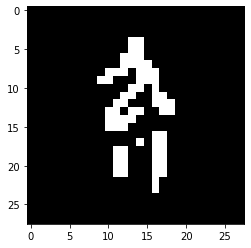

In [47]:
umap_embedding = {
    "editions": [entry["edition"] for entry in dataset],
    "annotations": [entry["annotation"] for entry in dataset],
    "display_images": torch.cat([validation_transforms(entry["image"]).unsqueeze(0) for entry in dataset]),
    "pitch_embeddings": torch.Tensor(umap_pitch.embedding_),
    "secondary_embeddings": torch.Tensor(umap_secondary.embedding_)
}
with open("umap_embeddings.pkl", "ab") as file_handle:
    pickle.dump(umap_embedding, file_handle)
    
plt.imshow(umap_embedding["display_images"][0].squeeze(), cmap="gray")

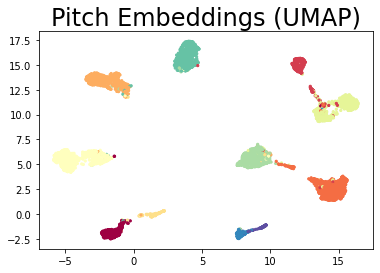

In [48]:
with open("umap_embeddings.pkl", "rb") as file_handle:
    umap_embeddings = pickle.load(file_handle)

plt.scatter(umap_embeddings["pitch_embeddings"][:, 0], umap_embeddings["pitch_embeddings"][:, 1], s=5, c=datasets["pitch"].y, cmap='Spectral')
plt.title('Pitch Embeddings (UMAP)', fontsize=24);

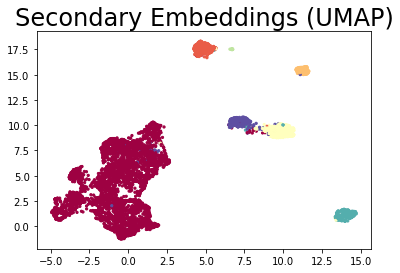

In [49]:
plt.scatter(umap_embeddings["secondary_embeddings"][:, 0], umap_embeddings["secondary_embeddings"][:, 1], s=5, c=datasets["secondary"].y, cmap='Spectral')
plt.title('Secondary Embeddings (UMAP)', fontsize=24);

In [57]:
import os
import cv2
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.neighbors import NearestNeighbors
import pickle

class FashionCNN(nn.Module):
    def __init__(self, num_output_classes):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=num_output_classes)
        self.logits = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.logits(out)
        
        return out
    
    def get_representation(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        return out

class TemperatureScalingCalibrationModule(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

        # the single temperature scaling parameter, the initialization value doesn't
        # seem to matter that much based on some ad-hoc experimentation
        self.temperature = nn.Parameter(torch.ones(1))
        
    def get_representation(self, x):
        return self.model.get_representation(x)
        
    def forward_unscaled(self, x):
        logits = self.model(x)
        scores = nn.functional.softmax(logits, dim=1)
        return scores
    
    def forward(self, x):
        scaled_logits = self.forward_logit(x)
        scores = nn.functional.softmax(scaled_logits, dim=1)
        return scores

    def forward_logit(self, x):      
        logits = self.model(x)
        return logits / self.temperature

    def fit(self, data_loader, n_epochs: int = 10, batch_size: int = 64, lr: float = 0.01):
        """fits the temperature scaling parameter."""
        assert isinstance(data_loader, DataLoader), "data_loader must be an instance of DataLoader"
    
        print(self.temperature.requires_grad)
        
        self.freeze_base_model()
        criterion = nn.NLLLoss()
        optimizer = optim.SGD(self.parameters(), lr=lr)
        
        for epoch in range(n_epochs):
            for batch in data_loader:
                images, labels, _ = batch  
                images, labels = images.to(device), labels.to(device)
        
                self.zero_grad()
                scaled_logits = self.forward_logit(images)  # Use forward to get scaled logits
                loss = criterion(scaled_logits, labels)
                loss.backward()
                optimizer.step()
    
        return self


    def freeze_base_model(self):
        """remember to freeze base model's parameters when training temperature scaler"""
        self.model.eval()
        for parameter in self.model.parameters():
            parameter.requires_grad = False
        return self

def get_transforms():
    def remove_small_blobs(image):  # remove small isolated connected black areas
        noise_removal_threshold = 1  
        mask = np.ones_like(image)*255
        contours, hierarchy = cv2.findContours(255-image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for contour in contours:
          area = cv2.contourArea(contour)
          if area >= noise_removal_threshold:
            cv2.fillPoly(mask, [contour], 0)
        return mask


    def crop_excess_whitespace(image):
        gray = 255*(image < 128).astype(np.uint8) #reverse the colors
        coords = cv2.findNonZero(gray) # Find all non-zero points (text)
        x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
        rect = image[y:y+h, x:x+w]
        return rect


    def shrink(target_size=28):
        def inner(input_image):
            t_size = target_size - 7

            original_width = input_image.shape[-1]
            original_height = input_image.shape[-2]
            aspect_ratio = original_width / original_height

            if aspect_ratio > 1:
                w = int(t_size)
                h = int(t_size / aspect_ratio)
            else: 
                w = int(t_size * aspect_ratio)
                h = int(t_size)

            output_image = transforms.Resize(size=(h, w), interpolation=transforms.InterpolationMode.NEAREST_EXACT)(input_image)
            return output_image

        return inner

    def paste_to_square(target_size=28):
        def inner(input_image):
            ## Modify the function to extend the
            ## input image to a square of 40x40.
            ## Tip: This can be done by clever use
            ## of the Pad function
            ## https://pytorch.org/vision/stable/generated/torchvision.transforms.Pad.html
            ## Also make sure that the added padding
            ## on each side is random, i.e., the 
            ## data itself is augmented by its
            ## position in the square.

            pad_width = target_size - input_image.shape[-1]
            pad_height = target_size - input_image.shape[-2]

            left_pad = pad_width//2
            top_pad = pad_height//2

            right_pad = pad_width - left_pad
            bottom_pad = pad_height - top_pad

            output_image = transforms.Pad(padding=(left_pad, top_pad, right_pad, bottom_pad), fill=1)(input_image) 
            return output_image

        return inner

    def normalize():
        mean = 0.8497
        std = 0.0518
        return transforms.Normalize(mean=mean, std=std)

    evaluation_transforms = transforms.Compose([
        transforms.ToTensor(),
        shrink(),
        paste_to_square(),
        lambda img: transforms.functional.invert(img), # inverts image, needed for rotations
        normalize(), # normalize mean and variance
    ])

    display_transforms = transforms.Compose([
        transforms.ToTensor(),
        shrink(target_size=60),
        paste_to_square(target_size=60),
        lambda img: transforms.functional.invert(img), # inverts image, needed for rotations
        normalize(), # normalize mean and variance
    ])
    
    return {
        "evaluation": evaluation_transforms,
        "display": display_transforms,
        "class_to_annotation": {
            "pitch": {0: "HE", 1: "SI", 2: "YI", 3: "SHANG", 4: "GOU", 5: "CHE", 6: "GONG", 7: "FAN", 8: "LIU", 9: "WU", 10: "GAO_WU"},
            "secondary": {0: None, 1: "DA_DUN", 2: "XIAO_ZHU", 3: "DING_ZHU", 4: "DA_ZHU", 5: "ZHE", 6: "YE"}
        }}

def load_model():
    pitch_model = TemperatureScalingCalibrationModule(FashionCNN(num_output_classes=11))
    pitch_model.load_state_dict(torch.load("./model_pitch.std"))
    secondary_model = TemperatureScalingCalibrationModule(FashionCNN(num_output_classes=7))
    secondary_model.load_state_dict(torch.load("./model_secondary.std"))
    with open("umap_models.pkl", "rb") as file_handle:
        umap_models = pickle.load(file_handle)
    with open("umap_embeddings.pkl", "rb") as file_handle:
        umap_embeddings = pickle.load(file_handle)
    
    return {
        "model": {"pitch": pitch_model, "secondary": secondary_model},
        "umap_models": umap_models,
        "umap_embeddings": umap_embeddings,
    }

def predict_similar(image_list, models, transforms):
    concatenation = torch.cat([transforms["evaluation"](entry).unsqueeze(0) for entry in image_list])
    
    pitch_latent = pitch_model.get_representation(concatenation).detach().numpy()
    secondary_latent = secondary_model.get_representation(concatenation).detach().numpy()

    current_pitch_embedding = models["umap_models"]["pitch"](pitch_latent)
    current_secondary_embedding = models["umap_models"]["secondary"](secondary_latent)

    pitch_nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(models["umap_embeddings"]["pitch_embeddings"])
    pitch_distances, pitch_indices = pitch_nbrs.kneighbors(current_pitch_embedding)

    secondary_nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(models["umap_embeddings"]["secondary_embeddings"])
    secondary_distances, secondary_indices = secondary_nbrs.kneighbors(current_secondary_embedding)

    def get_dict_pitch(distance, idx):
        image = models["umap_embeddings"]["display_images"][idx]
        edition = models["umap_embeddings"]["editions"][idx]
        annotation = models["umap_embeddings"]["annotations"][idx]["pitch"]
        return {"image": image,
                "edition": edition,
                "distance": distance,
                "similarity": 1/distance if distance > 0 else 9999,
                "annotation": transforms["class_to_annotation"]["pitch"][annotation]}

    def get_dict_secondary(distance, idx):
        image = models["umap_embeddings"]["display_images"][idx]
        edition = models["umap_embeddings"]["editions"][idx]
        annotation = models["umap_embeddings"]["annotations"][idx]["secondary"]
        return {"image": image,
                "edition": edition,
                "distance": distance,
                "similarity": 1/distance if distance > 0 else 9999,
                "annotation": transforms["class_to_annotation"]["secondary"][annotation]}

    output = {"pitch": 
    [[get_dict_pitch(distance, idx) for distance, idx in zip(pitch_distances[IDX], pitch_indices[IDX])] for IDX in range(len(image_list))],
            "secondary": 
    [[get_dict_secondary(distance, idx) for distance, idx in zip(secondary_distances[IDX], secondary_indices[IDX])] for IDX in range(len(image_list))]
           }

    return output

def predict_notation(image_list, models, transforms):
    concatenation = torch.cat([transforms["evaluation"](entry).unsqueeze(0) for entry in image_list])
    
    pitch_predictions = pitch_model.forward(concatenation).detach().numpy()
    secondary_predictions = secondary_model.forward(concatenation).detach().numpy()
    
    def get_first_three(tensor):
        first_confidence = tensor.max()
        first_label = tensor.argmax()
        tensor[first_label] = 0
            
        second_confidence = tensor.max()
        second_label = tensor.argmax()
        tensor[second_label] = 0
            
        third_confidence = tensor.max()
        third_label = tensor.argmax()
        tensor[third_label] = 0
        
        return [first_label, second_label, third_label], [first_confidence, second_confidence, third_confidence]
            

    def get_dict_pitch(idx):
        annotations, confidences = get_first_three(pitch_predictions[idx])
        annotations = [transformations["class_to_annotation"]["pitch"][annotation] for annotation in annotations]
        return {
            "annotations": annotations,
            "confidences": confidences
        }

    def get_dict_secondary(idx):
        annotations, confidences = get_first_three(secondary_predictions[idx])
        annotations = [transformations["class_to_annotation"]["secondary"][annotation] for annotation in annotations]
        return {
            "annotations": annotations,
            "confidences": confidences
        }

    output = {"pitch": 
    [get_dict_pitch(idx) for idx in range(len(image_list))],
            "secondary": 
    [get_dict_secondary(idx) for idx in range(len(image_list))]
           }

    return output

In [58]:
model = load_model()
transformations = get_transforms()

In [59]:
def validate(model, images_, labels_):  
    def loss_function(x, y):
        return nn.NLLLoss()(x, y)
    
    model.eval()

    total_step = len(images_)
    
    print(f"Validating with")
    
    pred_y = []
    full_labels = []
    outputs = []
        
    for i, (images, labels) in enumerate(zip(images_, labels_)):
        images = images.unsqueeze(0)
        # gives batch data, normalize x when iterate train_loader
        b_x = images   # batch x
        b_y = labels

        output = model(b_x)
        outputs.append(output)
        loss = loss_function(output[0], torch.tensor(b_y))
        pred_y += torch.argmax(output, dim=1)
        full_labels += [labels]
    
    labels = torch.Tensor(full_labels)
    pred_y = torch.Tensor(pred_y)
    
    total_accuracy = (pred_y == labels).sum() / float(len(pred_y))

    print ('    Acc.(Total): {:.2f}%%'.format(total_accuracy*100))
    
    return outputs, pred_y

def get_transformation(model, l):
    return model.get_representation(l)
    
def get_datasets(dataset, transformation=True):
    class Dataset(torch.utils.data.Dataset):
        def __init__(self, return_pitch, dataset: list, model=None, transform=None):
            model.eval()
            concatenation = torch.cat([transform(entry["image"]).unsqueeze(0) for entry in dataset])
            
            if transformation:
                self.X = get_transformation(model, concatenation)
            else:
                self.X = [transform(entry["image"]) for entry in dataset]
                
            self.original = [entry["image"] for entry in dataset]
            
            if return_pitch:
                self.y = [entry["annotation"]["pitch"] for entry in dataset]
            else:
                self.y = [entry["annotation"]["secondary"] for entry in dataset]


            self.transform = transform

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            sample = self.X[idx]
            label = self.y[idx]
            return sample, label
    
    pitch_data = Dataset(return_pitch=True, dataset=dataset, model=model["model"]["pitch"], transform=transformations["evaluation"])
    secondary_data = Dataset(return_pitch=False, dataset=dataset, model=model["model"]["secondary"], transform=transformations["evaluation"])
    return {"pitch": pitch_data, "secondary": secondary_data}


In [60]:
with open("train_data.pkl", "rb") as file_handle:
    dataset = pickle.load(file_handle)
datasets = get_datasets(dataset, False)

Validating with
    Acc.(Total): 100.00%%
tensor([3.])


/home/tristan/.local/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


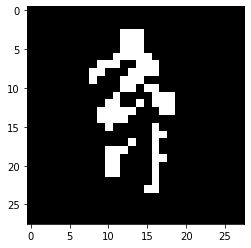

In [63]:

#plt.imshow(datasets["pitch"][IDX][0].squeeze(), cmap="gray")
display_orig = datasets[MODE][IDX][0].squeeze() #datasets[MODE].X[IDX].squeeze()
plt.imshow(display_orig.detach().numpy(), cmap="gray")
outputs, pred_y = validate(model["model"][MODE], [datasets[MODE][idx][0] for idx in range(1)], [datasets[MODE][idx][1] for idx in range(46)])

pred_y_old = pred_y
print(pred_y)
result = [transformations["class_to_annotation"][MODE][int(cl)] for cl in pred_y]
real = [transformations["class_to_annotation"][MODE][int(cl)] for cl in [datasets[MODE][idx][1] for idx in range(46)]]

[[-2.3176017 13.93518  ]]


/home/tristan/.local/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


[[11.428944 15.824191]]


/home/tristan/.local/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


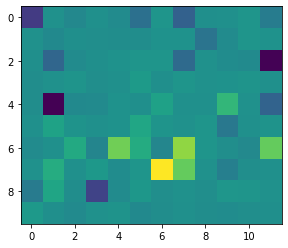

In [93]:
print(model["umap_models"]["pitch"](get_transformation(model["model"]["pitch"], datasets[MODE][IDX][0].unsqueeze(0)).detach().numpy()))
print(model["umap_models"]["secondary"](get_transformation(model["model"]["secondary"], datasets[MODE][IDX][0].unsqueeze(0)).detach().numpy()))

plt.imshow(get_transformation(model["model"]["secondary"], datasets[MODE][IDX][0].unsqueeze(0)).reshape(10, 12).detach().numpy())

NameError: name 'model' is not defined

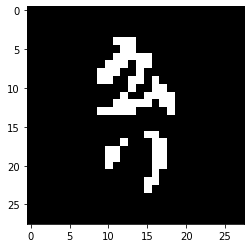

In [36]:
IDX = 0
MODE = "pitch"
with open("./test_data.pkl", "rb") as file_handle:
    l = pickle.load(file_handle)
    pred_y_old = torch.Tensor([element["annotation"][MODE] for element in l])
    raw_image_list = [element["image"] for element in l]
    image_list = [validation_transforms(element["image"]) for element in l]
display_img = image_list[IDX]
plt.imshow(display_img[0], cmap="gray")

outputs, pred_y_new = validate(model["model"][MODE], image_list, [datasets[MODE][idx][1] for idx in range(len(image_list))])

print(pred_y_new)

result = [transformations["class_to_annotation"][MODE][int(cl)] for cl in pred_y_new]
    
#print(outputs)
print(outputs[0])

In [70]:
#print(pred_y_old)
#print(len(pred_y_new))

plt.imshow(display_img[0], cmap="gray")

print(sum(pred_y_old == pred_y_new)/len(pred_y_old)*100)

tensor(94.8611)


In [71]:
predict_notation(raw_image_list, model, transformations)

L1 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [3.8907, 3.6683, 3.6683,  ..., 3.6683, 3.6683, 3.6683]],

         [[3.5488, 3.5488, 3.5488,  ..., 3.5488, 3.5488, 3.5488],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...

L1 tensor([[[[0.3639, 0.1527, 0.1527,  ..., 0.1527, 0.1527, 0.1527],
          [0.1527, 0.1527, 0.1527,  ..., 0.1527, 0.1527, 0.1527],
          [0.1527, 0.1527, 0.1527,  ..., 0.1527, 0.1527, 0.1527],
          ...,
          [0.1527, 0.1527, 0.1527,  ..., 0.1527, 0.1527, 0.1527],
          [0.1527, 0.1527, 0.1527,  ..., 0.1527, 0.1527, 0.1527],
          [0.1527, 0.1527, 0.1527,  ..., 0.1527, 0.1527, 0.1527]],

         [[1.6689, 1.6689, 1.6689,  ..., 1.6689, 1.6689, 2.2066],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...

{'pitch': [{'annotations': ['SHANG', 'LIU', 'HE'],
   'confidences': [0.9999807, 1.92075e-05, 6.005951e-08]},
  {'annotations': ['GONG', 'SI', 'YI'],
   'confidences': [0.9940096, 0.004628699, 0.00079373695]},
  {'annotations': ['LIU', 'CHE', 'SHANG'],
   'confidences': [0.90809095, 0.09190905, 9.879668e-09]},
  {'annotations': ['HE', 'SHANG', 'GOU'],
   'confidences': [0.5599948, 0.42428702, 0.015608837]},
  {'annotations': ['HE', 'SHANG', 'WU'],
   'confidences': [0.99999094, 9.112547e-06, 1.472142e-09]},
  {'annotations': ['YI', 'GONG', 'SI'],
   'confidences': [0.999984, 1.5128919e-05, 8.6842243e-07]},
  {'annotations': ['SHANG', 'LIU', 'HE'],
   'confidences': [0.9998894, 0.00010686749, 3.690409e-06]},
  {'annotations': ['SHANG', 'LIU', 'SI'],
   'confidences': [0.9835053, 0.016484953, 3.4594727e-06]},
  {'annotations': ['WU', 'HE', 'GOU'],
   'confidences': [0.90717703, 0.075064376, 0.008904688]},
  {'annotations': ['LIU', 'SHANG', 'HE'],
   'confidences': [0.9109926, 0.08647313,

In [73]:
prediction = predict_similar(raw_image_list, model, transformations)["pitch"]

In [74]:
len(prediction)

1440